[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Generating news data...
Preprocessing stock data...
Preprocessing news data...
Merging datasets...
Saved AAPL_processed_data.csv with shape (737, 15)

Sample processed data:
           Date        Open        High         Low       Close    Volume  \
732  2022-12-23  129.415299  130.898059  128.150012  130.344498  63814900   
733  2022-12-27  129.870028  129.899682  127.240596  128.535538  69007800   
734  2022-12-28  128.179661  129.524031  124.423341  124.591385  85438400   
735  2022-12-29  126.518978  128.980357  126.261971  128.120361  75703700   
736  2022-12-30  126.934157  128.456450  125.965417  128.436676  77034200   

     Dividends  Stock Splits Ticker  Daily_Return       SMA_5      SMA_20  \
732        0.0           0.0   AAPL     -0.002798  131.315201  139.044336   
733        0.0           0.0   AAPL     -0.013878  130.852582  138.342991   
734        0.0           0.0   AAPL     -0.030685  129.614972  137.595187   
735        0.0           0.0   AAPL      0.028324  128.

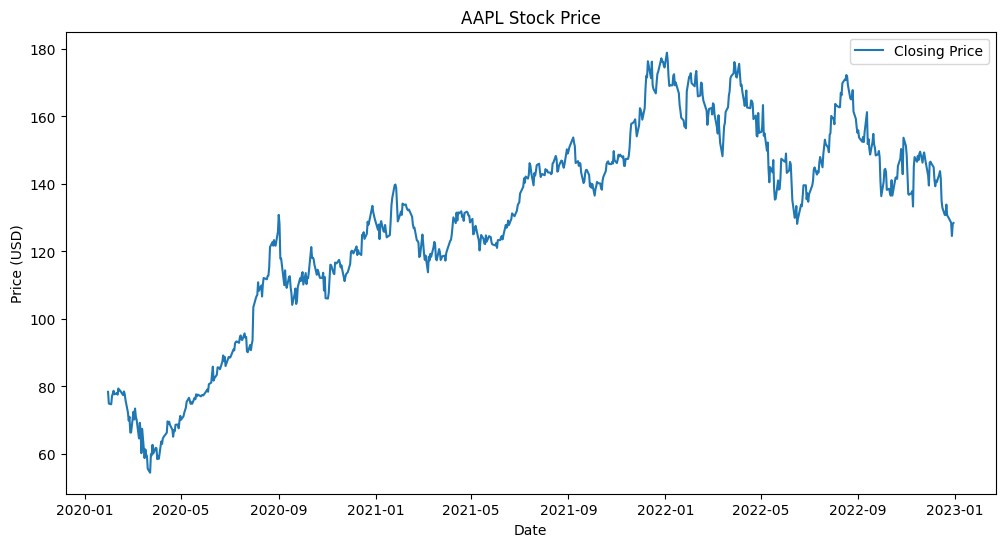

In [1]:
# Install required libraries
!pip install yfinance requests beautifulsoup4 nltk pandas numpy scikit-learn

# Import necessary libraries
import os
import time
import random
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Initialize NLTK components
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

# Create directories
os.makedirs('data', exist_ok=True)

# 1. Scrape Apple Stock Data from Yahoo Finance
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date, interval="1d")
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['Date']).dt.date
    data['Ticker'] = ticker
    return data

# 2. Simulate News Scraping (replace with real scraping if needed)
def generate_simulated_news(ticker, start_date, end_date):
    headlines = [
        "Apple announces record earnings",
        "New iPhone features leaked",
        "Supply chain issues reported",
        "Apple stock hits new high",
        "Regulatory concerns arise"
    ]
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    return pd.DataFrame({
        'Date': np.random.choice(dates, size=100),
        'Ticker': ticker,
        'Headline': np.random.choice(headlines, size=100),
        'Source': np.random.choice(['CNBC', 'Reuters', 'Bloomberg'], size=100)
    })

# 3. Preprocess Stock Data
def preprocess_stock_data(df):
    # Calculate technical indicators
    df['Daily_Return'] = df['Close'].pct_change()
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Daily_Return'].rolling(window=5).std()

    # Drop missing values
    df.dropna(inplace=True)
    return df

# 4. Preprocess News Data
def preprocess_news_data(df):
    sia = SentimentIntensityAnalyzer()
    df['Sentiment'] = df['Headline'].apply(lambda x: sia.polarity_scores(x)['compound'])
    df['Date'] = pd.to_datetime(df['Date']).dt.date

    # Aggregate daily sentiment
    daily_sentiment = df.groupby(['Date', 'Ticker']).agg({
        'Sentiment': ['mean', 'count']
    }).reset_index()

    daily_sentiment.columns = ['Date', 'Ticker', 'Sentiment_Score', 'News_Count']
    return daily_sentiment

# 5. Combine Data Sources
def combine_data(stock_df, news_df):
    merged = pd.merge(stock_df, news_df,
                     on=['Date', 'Ticker'],
                     how='left')
    merged.fillna(0, inplace=True)
    return merged

# 6. Save to CSV
def save_data(df, filename):
    df.to_csv(f'data/{filename}.csv', index=False)
    print(f"Saved {filename}.csv with shape {df.shape}")

# Main Execution Pipeline
if __name__ == "__main__":
    # Parameters
    TICKER = 'AAPL'
    START_DATE = '2020-01-01'
    END_DATE = '2023-01-01'

    # 1. Get stock data
    print("Downloading stock data...")
    stock_df = get_stock_data(TICKER, START_DATE, END_DATE)

    # 2. Generate simulated news data
    print("Generating news data...")
    news_df = generate_simulated_news(TICKER, START_DATE, END_DATE)

    # 3. Preprocess data
    print("Preprocessing stock data...")
    processed_stock = preprocess_stock_data(stock_df)

    print("Preprocessing news data...")
    processed_news = preprocess_news_data(news_df)

    # 4. Combine data
    print("Merging datasets...")
    final_df = combine_data(processed_stock, processed_news)

    # 5. Save results
    save_data(final_df, f'{TICKER}_processed_data')

    # Show sample data
    print("\nSample processed data:")
    print(final_df.tail())

    # Plot closing price
    plt.figure(figsize=(12, 6))
    plt.plot(final_df['Date'], final_df['Close'], label='Closing Price')
    plt.title(f'{TICKER} Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()